# importieren wichtige Pakete

In [259]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import make_scorer
from numpy.polynomial.polynomial import Polynomial
pd.set_option('display.max_columns', 500)
# für Visualisierung

#plt.rcParams.keys()
plt.rcParams['ytick.labelsize'] = "large"
plt.rcParams['xtick.labelsize'] = "large"
plt.rcParams['axes.labelsize'] = "large"
plt.rcParams['figure.titlesize'] = "x-large"


import warnings
warnings.filterwarnings("ignore")


## Daten lesen und visualisieren

### Load the data and compute RUL

In [228]:
# Laden die Daten FD001 als Beispiel
def read_data(file_name):
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["Operation Setting "+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["Sensor Measure"+str(i) for i in range(1,22)]
    
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    
    data = pd.read_csv(file_name, delim_whitespace=True, header=None)
    print("Größe der Daten : Rows {}, Columns {}".format(train_data.shape[0], train_data.shape[1]))
    data.columns = input_file_column_names
    return data

In [229]:
def calculate_rul_and_remove_operational (df):
    df['rul'] = df.groupby('UnitNumber')['Cycle'].transform(lambda x: x.max() - x)
    df['rul'] = df['rul'].apply(lambda x: min(x, 130))
    df.drop(['Operation Setting 1','Operation Setting 2','Operation Setting 3', 'Cycle'], axis=1, inplace=True)
    return df

In [230]:
train_data = read_data('./data/train_FD001.txt')
train_data = calculate_rul_and_remove_operational(train_data)
train_data.head()

Größe der Daten : Rows 20631, Columns 26


,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,130
1,1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,130
2,1,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,130
3,1,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,130
4,1,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,130


## Schritt 1: Daten Normalisierung und Glättung 

### Entferne Spalten mit konstantem Werten

In [232]:
def identify_and_remove_unique_columns(Dataframe):
    unique_counts = Dataframe.nunique()
    # identify columns with only one unique value and drop them (constant values)
    record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
    to_drop = list(record_single_unique['feature'])
    Dataframe = Dataframe.drop(columns = to_drop)
    return Dataframe

In [235]:
print("Größe vor der Verarbeitung ", train_data.shape)

train_data_relevant = identify_and_remove_unique_columns(train_data)
print("Größe Nach der Verarbeitung", train_data_relevant.shape)

sensor_columns = [col for col in train_data_relevant.columns if 'Sensor Measure' in col]
train_data_relevant

Größe vor der Verarbeitung  (20631, 23)
Größe Nach der Verarbeitung (20631, 17)


,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,130
1,1,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,130
2,1,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,130
3,1,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,130
4,1,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


### Daten Normalisieren mit Z-Score

In [236]:
scaler = StandardScaler()

# Normalisierung der Sensormessungen
normalized_train_data = train_data_relevant.copy()
normalized_train_data[sensor_columns] =  scaler.fit_transform(normalized_train_data[sensor_columns])
normalized_train_data

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,-1.721725,-0.134255,-0.925936,0.141683,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427,130
1,1,-1.061780,0.211528,-0.643726,0.141683,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922,130
2,1,-0.661813,-0.413166,-0.525953,0.141683,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423,130
3,1,-0.661813,-1.261314,-0.784831,0.141683,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792,130
4,1,-0.621816,-1.251528,-0.301518,0.141683,0.714393,-0.516338,-0.457059,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,1.618000,1.216258,2.188375,0.141683,-2.189329,1.315066,0.012547,1.980044,-2.607969,2.278282,-0.322542,1.425294,2.446751,-1.805173,-2.921113,4
20627,100,1.717992,2.279706,2.738351,0.141683,-2.833345,1.878576,-0.006020,1.867718,-2.350355,1.722087,-0.380207,1.913240,1.155367,-2.856395,-1.203764,3
20628,100,1.478011,1.946971,2.138377,0.141683,-2.742957,2.019453,0.029755,2.054927,-1.902919,2.000184,-0.141684,3.265092,3.092444,-2.081810,-3.292481,2
20629,100,1.098043,2.403666,1.955051,0.141683,-3.036719,2.160330,0.383884,3.178182,-2.363913,1.861136,-0.233948,2.579834,1.155367,-2.911722,-2.085072,1


### Polynomial fitting

In [234]:
# Polynomial fitting
def poly_fit(df, degree):
    fitted_data = np.zeros(df.shape)
    for i, column in enumerate(df.columns):
        poly = Polynomial.fit(range(len(df)), df[column], degree)
        fitted_data[:, i] = poly(range(len(df)))
    return pd.DataFrame(fitted_data, columns=df.columns)

In [237]:
def fit_polynomial_for_all_units (df, col_name_unit_number='UnitNumber'):
    X_final = df.copy()[df[col_name_unit_number] == 1]
    X_final[sensor_columns] = poly_fit(X_final[sensor_columns], degree=3)
    X_final

    for id in range(2,len(df[col_name_unit_number].unique())+1):
        #apply the polynomial fitting to each unit
        unit_data = df[df[col_name_unit_number] == id]
        unit_data = poly_fit(unit_data[sensor_columns], degree=3)
        unit_data[col_name_unit_number] = id
        X_final=pd.concat([X_final, unit_data], axis=0)
    return X_final

In [242]:
polynomial_train_data = normalized_train_data.copy()
polynomial_train_data[sensor_columns + ['UnitNumber']] = fit_polynomial_for_all_units(normalized_train_data[sensor_columns + ['UnitNumber']]).reset_index(drop=True)
polynomial_train_data

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,-0.798512,-0.466045,-0.983026,0.141683,0.930287,-0.569979,-0.687156,-1.111285,0.870001,-0.773328,-0.552246,-0.970137,-0.896622,1.015534,1.062681,130
1,1,-0.794304,-0.472907,-0.980079,0.141683,0.925949,-0.566511,-0.686939,-1.100674,0.870436,-0.766315,-0.555730,-0.956198,-0.892935,1.001607,1.051339,130
2,1,-0.790239,-0.479704,-0.977208,0.141683,0.921728,-0.563196,-0.686718,-1.090309,0.870859,-0.759472,-0.559093,-0.942654,-0.889361,0.988028,1.040274,130
3,1,-0.786313,-0.486435,-0.974409,0.141683,0.917621,-0.560029,-0.686495,-1.080185,0.871266,-0.752793,-0.562339,-0.929500,-0.885896,0.974791,1.029482,130
4,1,-0.782522,-0.493098,-0.971679,0.141683,0.913625,-0.557005,-0.686270,-1.070297,0.871655,-0.746275,-0.565470,-0.916729,-0.882537,0.961891,1.018957,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,1.623472,1.702633,2.173965,0.191787,-2.372238,2.001077,0.068997,2.214583,-2.177596,2.004340,-0.201257,2.109335,1.824536,-2.266227,-1.960478,4
20627,100,1.650759,1.732527,2.223758,0.196069,-2.425160,2.045845,0.068755,2.256343,-2.224562,2.042738,-0.208027,2.156722,1.861622,-2.314811,-1.998112,3
20628,100,1.678255,1.762674,2.274249,0.200485,-2.478814,2.091193,0.068474,2.298530,-2.272126,2.081496,-0.214939,2.204733,1.899203,-2.364010,-2.036144,2
20629,100,1.705960,1.793075,2.325441,0.205036,-2.533206,2.137124,0.068154,2.341149,-2.320291,2.120615,-0.221995,2.253371,1.937283,-2.413829,-2.074577,1


## Schritt 2: Feature-Auswahl mit Lasso-Regression

In [247]:
def lasso_feature_selection(X, y, alpha=2.5):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    return np.array(X.columns)[lasso.coef_ != 0]

In [249]:
selected_features = lasso_feature_selection(polynomial_train_data[sensor_columns], polynomial_train_data['rul'])
selected_features

array(['Sensor Measure4', 'Sensor Measure9', 'Sensor Measure11'],
      dtype=object)

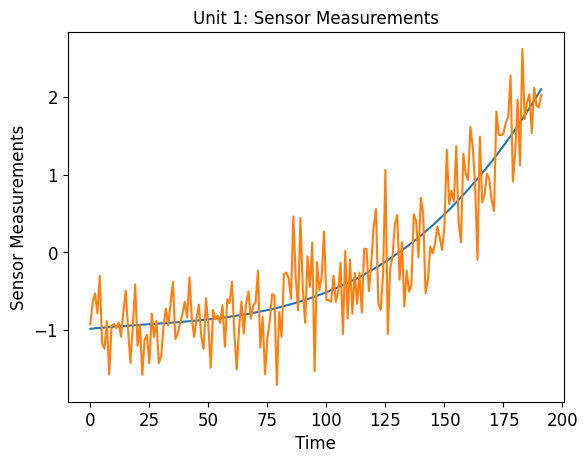

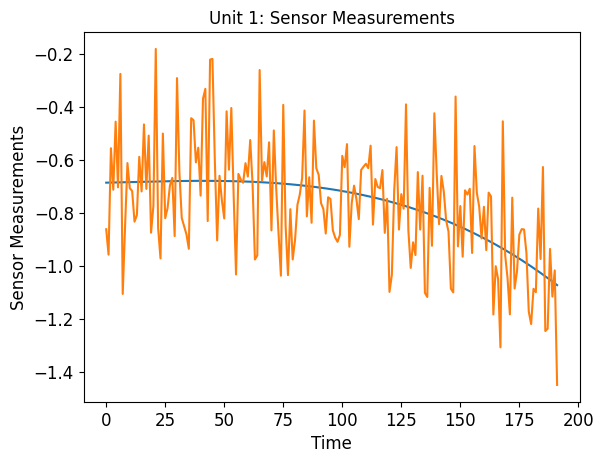

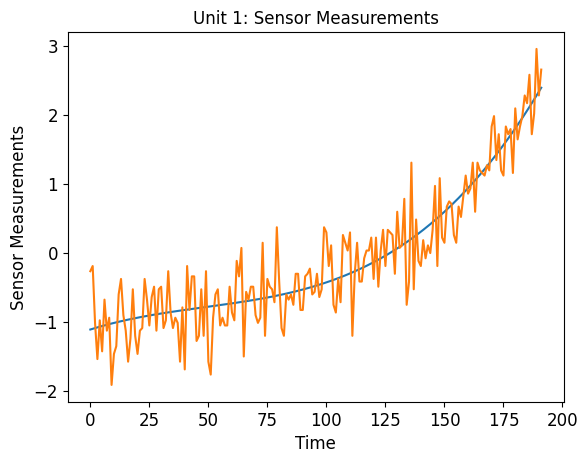

In [250]:
# visualize the unsmoothed and smmothed data for unit 1 for each sensor separately
for col in selected_features:
    plt.plot(polynomial_train_data[polynomial_train_data['UnitNumber'] == 1][col], label=col)
    plt.plot(normalized_train_data[normalized_train_data['UnitNumber'] == 1][col], label=col+'_original')
        
    plt.title('Unit 1: Sensor Measurements')
    plt.xlabel('Time')
    plt.ylabel('Sensor Measurements')
    plt.show()

### Schritt 3: Feature-Extraktion 

In [256]:
selected_polynomial_train_data = polynomial_train_data[[ 'UnitNumber', 'rul']+list(selected_features)]
selected_polynomial_train_data

,UnitNumber,rul,Sensor Measure4,Sensor Measure9,Sensor Measure11
0,1,130,-0.983026,-0.687156,-1.111285
1,1,130,-0.980079,-0.686939,-1.100674
2,1,130,-0.977208,-0.686718,-1.090309
3,1,130,-0.974409,-0.686495,-1.080185
4,1,130,-0.971679,-0.686270,-1.070297
...,...,...,...,...,...
20626,100,4,2.173965,0.068997,2.214583
20627,100,3,2.223758,0.068755,2.256343
20628,100,2,2.274249,0.068474,2.298530
20629,100,1,2.325441,0.068154,2.341149


In [299]:
selected_polynomial_train_data[selected_polynomial_train_data['UnitNumber'] == 1]

,UnitNumber,rul,Sensor Measure4,Sensor Measure9,Sensor Measure11
0,1,130,-0.983026,-0.687156,-1.111285
1,1,130,-0.980079,-0.686939,-1.100674
2,1,130,-0.977208,-0.686718,-1.090309
3,1,130,-0.974409,-0.686495,-1.080185
4,1,130,-0.971679,-0.686270,-1.070297
...,...,...,...,...,...
187,1,4,1.906979,-1.046916,2.167012
188,1,3,1.955072,-1.053479,2.222019
189,1,2,2.003728,-1.060119,2.277751
190,1,1,2.052949,-1.066836,2.334216


In [340]:
def extract_features(df, window_length=20, stride=20):
    features = []
    targets = []
    unit_numbers = []
    for unit in df['UnitNumber'].unique():
        unit_df = df[df['UnitNumber'] == unit]
        for start in range(len(unit_df) - window_length,0, -stride):
            end = start + window_length 
            window = unit_df.iloc[start:end]

            feature_vector = []
            for sensor in selected_features:
                mean_val = window[sensor].mean()
                trend = np.polyfit(range(window_length), window[sensor], 1)[0]
                feature_vector.extend([mean_val, trend])
                
                #plt.plot(window[sensor])
                #plt.scatter(start+10, mean_val, color='red', label='Mean Value')
               
            features.append(feature_vector)
            unit_numbers.extend([unit])
            targets.append(unit_df.iloc[end-1]['rul'])
            
    #print("Daten genutzt:", len(unit_df), "bis", start)
    cols = []
    for sensor in selected_features:
        cols.extend([sensor + '_mean', sensor + '_trend'])
    return_df = pd.DataFrame(data=np.array(features), columns=cols)
    return_df['UnitNumber'] = unit_numbers
    return return_df, pd.DataFrame(targets, columns=['rul'])

Daten genutzt: 192 bis 12


,Sensor Measure4_mean,Sensor Measure4_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber
0,1.661341,0.044825,-1.013371,-0.006121,1.888744,0.050809,1
1,0.867834,0.034707,-0.904978,-0.004741,1.003459,0.037997,1
2,0.263043,0.025954,-0.822498,-0.003530,0.353596,0.027266,1
3,-0.180334,0.018566,-0.762551,-0.002487,-0.102463,0.018617,1
4,-0.489601,0.012543,-0.721758,-0.001614,-0.406336,0.012048,1
5,-0.692060,0.007885,-0.696738,-0.000910,-0.599640,0.007560,1
6,-0.815014,0.004592,-0.684111,-0.000375,-0.723992,0.005153,1
7,-0.885765,0.002665,-0.680496,-0.000009,-0.821011,0.004826,1
8,-0.931615,0.002102,-0.682513,0.000188,-0.932312,0.006581,1


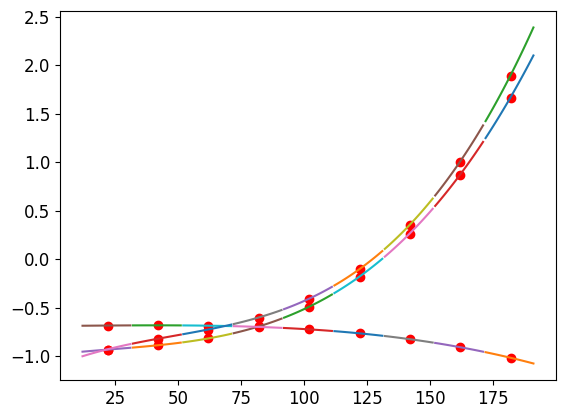

In [338]:
x_train , y_train = extract_features(selected_polynomial_train_data[selected_polynomial_train_data['UnitNumber'] == 1])
x_train 

In [342]:
x_train , y_train = extract_features(selected_polynomial_train_data)
pd.concat([x_train, y_train], axis=1)

,Sensor Measure4_mean,Sensor Measure4_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber,rul
0,1.661341,0.044825,-1.013371,-0.006121,1.888744,0.050809,1,0.0
1,0.867834,0.034707,-0.904978,-0.004741,1.003459,0.037997,1,20.0
2,0.263043,0.025954,-0.822498,-0.003530,0.353596,0.027266,1,40.0
3,-0.180334,0.018566,-0.762551,-0.002487,-0.102463,0.018617,1,60.0
4,-0.489601,0.012543,-0.721758,-0.001614,-0.406336,0.012048,1,80.0
...,...,...,...,...,...,...,...,...
967,-0.073475,0.009708,-0.020408,0.001917,-0.012851,0.013423,100,80.0
968,-0.227495,0.005975,-0.060563,0.002081,-0.238103,0.009223,100,100.0
969,-0.327989,0.004356,-0.102727,0.002118,-0.388388,0.005926,100,120.0
970,-0.417232,0.004850,-0.144347,0.002027,-0.481779,0.003533,100,130.0


## Train Random Forest regressor with C-Fold Cross validation

In [ ]:
def online_rul_prediction(data, rf_model):
    predictions = []
    for unit in data['UnitNumber'].unique():
        unit_data = data[data['UnitNumber'] == unit]
        rul_predictions = rf_model.predict(unit_data.drop(['UnitNumber', 'rul'], axis=1))
        n = len(rul_predictions)
        rul_predictions = rul_predictions - np.array(unit_data['rul'])
        predictions.append(sum(rul_predictions) / n)
        #print("Unit: {}, Average RUL Prediction: {}".format(unit, sum(rul_predictions) / n))
    return predictions

In [409]:
def custom_score(true_rul, predicted_rul):
    scores = []
    for true, pred in zip(true_rul, predicted_rul):
        if pred < true:
            score = np.exp((true - pred) / 13) - 1
        else:
            score = np.exp((pred - true) / 10) - 1
        scores.append(score)
    mean_score = np.mean(scores)
    return mean_score

# Create the custom scorer
custom_scorer = make_scorer(custom_score, greater_is_better=False)

In [419]:
rf_regressor = RandomForestRegressor()
param_grid = {
    'n_estimators': range(10, 101, 10),  # Number of trees in the forest
    'max_samples': np.arange(0.3,1,0.1)  # Minimum number of samples required to be at a leaf node
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, scoring=custom_score, n_jobs=-1)
#grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, n_jobs=-1)

grid_search.fit(x_train.drop(['UnitNumber'],axis=1), y_train)

best_rf_model = grid_search.best_estimator_

In [420]:
best_rf_model

RandomForestRegressor(max_samples=0.7000000000000002, n_estimators=80)

In [421]:
best_rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': 0.7000000000000002,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 80,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Prediction

In [365]:
#Testdaten laden
test_data =read_data('./data/test_FD001.txt')
test_data = calculate_rul_and_remove_operational(test_data)
test_data

Größe der Daten : Rows 20631, Columns 23


,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,30
1,1,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,29
2,1,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,28
3,1,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,27
4,1,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,4
13092,100,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,3
13093,100,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,2
13094,100,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,1


In [366]:
constant_columns=[col for col in test_data.columns if 'Sensor Measure' in col and not col in sensor_columns]
test_data.drop(constant_columns, axis=1, inplace=True)

In [367]:
test_data[sensor_columns] = scaler.transform(test_data[sensor_columns])
test_data

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,0.678077,-0.853550,-1.191480,0.141683,0.601408,-0.798093,-0.682579,-1.277396,0.415614,-0.919841,-0.954235,-0.985107,-0.781710,0.241943,0.774097,30
1,1,-1.941707,-0.338137,-1.501467,0.141683,1.674769,-1.220725,-0.490117,-0.154141,1.012195,-0.502695,-0.216648,-1.649034,-0.136018,1.127183,0.941305,29
2,1,-0.441831,-0.584426,-0.843717,0.141683,0.838677,-0.657216,-0.375093,-0.154141,0.754581,-0.919841,-0.715712,0.052112,-0.136018,1.459148,1.172256,28
3,1,-0.481827,-1.044384,-0.279297,0.141683,0.793483,-0.938970,-0.903570,-0.977861,-0.045381,-0.641744,-0.568929,-1.345067,-1.427402,1.016528,0.775945,27
4,1,-0.341839,-0.543650,-0.779276,0.141683,0.895170,-1.220725,-0.937081,-0.865536,0.998637,-0.919841,-0.745069,-1.041101,-2.073094,0.961200,1.138999,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,1.118041,1.456023,0.761769,0.141683,0.047780,-1.079848,3.492703,0.557254,-0.980929,-1.336988,3.644806,0.782698,0.509675,-0.919933,-0.852719,4
13092,100,1.078044,0.842747,1.457295,0.141683,-0.166892,-0.657216,3.416171,0.220277,-0.492817,-0.085548,3.517419,0.241425,1.155367,-1.362553,-0.116449,3
13093,100,1.518008,0.428459,-0.234855,0.141683,-0.370266,0.188048,3.693768,0.107952,-0.316554,-0.780793,3.852400,0.393408,1.155367,-1.085916,-0.781586,2
13094,100,1.158038,0.728573,1.158419,0.141683,0.002586,-0.375461,3.786150,0.257719,-0.113174,-0.224597,4.022249,0.772033,1.155367,-0.864606,-0.182962,1


In [368]:
test_data[sensor_columns+ ['UnitNumber']] = fit_polynomial_for_all_units(test_data[sensor_columns+ ['UnitNumber']] , 'UnitNumber').reset_index(drop=True)
test_data

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,-0.395087,-0.592943,-1.187806,0.141683,0.869647,-0.937151,-0.619258,-0.638693,0.590696,-0.724179,-0.710342,-1.043017,-0.428386,0.654008,0.882367,30
1,1,-0.516792,-0.696865,-1.081140,0.141683,0.906266,-0.933912,-0.622539,-0.710473,0.622994,-0.706996,-0.679442,-1.009464,-0.617906,0.750775,0.890341,29
2,1,-0.619541,-0.783011,-0.988056,0.141683,0.934914,-0.930910,-0.628644,-0.771179,0.652708,-0.691768,-0.654848,-0.975302,-0.780161,0.835342,0.895961,28
3,1,-0.704566,-0.852584,-0.907831,0.141683,0.956196,-0.927918,-0.637232,-0.821561,0.679895,-0.678296,-0.636073,-0.940774,-0.916758,0.908260,0.899389,27
4,1,-0.773101,-0.906787,-0.839741,0.141683,0.970718,-0.924711,-0.647964,-0.862368,0.704612,-0.666381,-0.622634,-0.906121,-1.029303,0.970079,0.900788,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,0.704569,0.786970,0.818852,0.211483,-0.208021,-0.594984,3.415351,0.474876,-0.157020,-0.653063,3.485400,0.560329,0.729894,-0.493009,-0.255929,4
13092,100,0.737345,0.819004,0.859630,0.223048,-0.229722,-0.579836,3.495819,0.504979,-0.181094,-0.643165,3.564363,0.590279,0.759979,-0.521460,-0.273580,3
13093,100,0.770566,0.851474,0.901067,0.234832,-0.251685,-0.564345,3.577445,0.535494,-0.205510,-0.633042,3.644460,0.620611,0.790367,-0.550322,-0.291384,2
13094,100,0.804235,0.884384,0.943169,0.246834,-0.273912,-0.548505,3.660236,0.566423,-0.230271,-0.622690,3.725701,0.651327,0.821059,-0.579597,-0.309343,1


In [369]:
test_data = test_data[['UnitNumber', 'rul'] + list(selected_features)].reset_index(drop=True)
test_data

,UnitNumber,rul,Sensor Measure4,Sensor Measure9,Sensor Measure11
0,1,30,-1.187806,-0.619258,-0.638693
1,1,29,-1.081140,-0.622539,-0.710473
2,1,28,-0.988056,-0.628644,-0.771179
3,1,27,-0.907831,-0.637232,-0.821561
4,1,26,-0.839741,-0.647964,-0.862368
...,...,...,...,...,...
13091,100,4,0.818852,3.415351,0.474876
13092,100,3,0.859630,3.495819,0.504979
13093,100,2,0.901067,3.577445,0.535494
13094,100,1,0.943169,3.660236,0.566423


In [370]:
test_data ,  cycle_number = extract_features(test_data)
test_df = pd.concat([test_data, cycle_number], axis=1)
test_df

,Sensor Measure4_mean,Sensor Measure4_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber,rul
0,-0.815628,-0.020380,-0.768992,0.008152,-0.879386,-0.000116,1,0.0
1,-0.233483,0.006847,-0.769675,-0.006136,-0.201162,0.016510,2,0.0
2,-0.378252,0.002481,-0.747352,0.004601,-0.238947,-0.004436,2,20.0
3,0.509226,0.026520,-0.672801,-0.004174,0.495329,0.019076,3,0.0
4,0.120431,0.013032,-0.603800,-0.002741,0.206696,0.010174,3,20.0
...,...,...,...,...,...,...,...,...
596,-0.805075,0.004202,-0.078801,0.012286,-0.886476,0.005544,100,80.0
597,-0.857954,0.001371,-0.249986,0.005278,-0.969163,0.002878,100,100.0
598,-0.875669,0.000686,-0.314466,0.001616,-1.010031,0.001362,100,120.0
599,-0.901143,0.002147,-0.339161,0.001300,-1.032106,0.000999,100,130.0


In [216]:
def online_rul_prediction(data, rf_model):
    predictions = []
    for unit in data['UnitNumber'].unique():
        unit_data = data[data['UnitNumber'] == unit]
        rul_predictions = rf_model.predict(unit_data.drop(['UnitNumber', 'rul'], axis=1))
        n = len(rul_predictions)
        rul_predictions = rul_predictions - np.array(unit_data['rul'])
        predictions.append(sum(rul_predictions) / n)
        #print("Unit: {}, Average RUL Prediction: {}".format(unit, sum(rul_predictions) / n))
    return predictions


In [422]:
RUL_FD001 = pd.read_table("./data/RUL_FD001.txt", header=None, delim_whitespace=True)
RUL_FD001

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [423]:
# Predict RUL for test data
predicted_rul = online_rul_prediction(test_df, best_rf_model)
predicted_rul

[114.375,
 94.625,
 46.75,
 67.3,
 77.21875,
 80.95,
 58.214285714285715,
 54.234375,
 109.75,
 41.138888888888886,
 67.625,
 41.075,
 35.47222222222222,
 71.0,
 103.75,
 75.825,
 31.0,
 31.083333333333332,
 66.625,
 12.333333333333334,
 46.0,
 69.875,
 75.1875,
 17.069444444444443,
 75.1875,
 100.95833333333333,
 55.166666666666664,
 56.267857142857146,
 53.828125,
 49.160714285714285,
 2.486111111111111,
 42.05357142857143,
 101.625,
 -1.2125,
 11.930555555555555,
 32.125,
 30.583333333333332,
 55.958333333333336,
 123.0,
 43.333333333333336,
 27.875,
 15.035714285714286,
 42.8125,
 74.375,
 52.625,
 42.285714285714285,
 99.41666666666667,
 94.45833333333333,
 0.2916666666666667,
 95.70833333333333,
 58.839285714285715,
 24.11111111111111,
 26.359375,
 62.354166666666664,
 83.575,
 25.416666666666668,
 52.67857142857143,
 22.0625,
 88.46875,
 55.67857142857143,
 20.946428571428573,
 19.738636363636363,
 47.55357142857143,
 24.671875,
 82.54166666666667,
 21.5,
 99.625,
 7.04166666666

In [424]:
print("Root mean squared error:", sqrt(mean_squared_error(RUL_FD001, predicted_rul)))
print("Custom score:", custom_score(RUL_FD001, predicted_rul))

Root mean squared error: 30.12647785275805
Custom score: 92733.88479321224


In [3]:
real_rul = pd.read_table("./data/RUL_FD001.txt", header=None, delim_whitespace=True).values

#plot the predicted RUL vs the real RUL for each data point in a scatter plot
plt.figure(figsize=(12,6))

plt.scatter(real_rul, predicted_rul)
plt.legend()
plt.title("Predicted RUL vs. real RUL for Motor 1")
plt.xlabel("Predicted RUL")
plt.ylabel("Real RUL")
plt.show()


NameError: name 'pd' is not defined